In [1]:
import sys
sys.path.append('./lib')

import numpy as np
import matplotlib.pyplot as plt
from  matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)

import pickle
from pathlib import Path

from dlt.model import PDFmodel
from dlt.distribution import Distribution

In [2]:
WEIGHTS_TOKEN = 'weights.h5'
def select_weight(epoch: int):
  return f"epoch_{int(epoch)}.{WEIGHTS_TOKEN}"

In [3]:
FIT_FOLDER = Path('../Results/fits/fit_250417-01-L2-50000')
SERIALIZATION_FOLDER = FIT_FOLDER / 'serialization'
SERIALIZATION_FOLDER.mkdir(parents=True, exist_ok=True)

PLOT_FOLDER = FIT_FOLDER / 'plots'
PLOT_FOLDER.mkdir(parents=True, exist_ok=True)

SAVE_PLOT = False
SAVE_NB = False
APPLY_LIM_KIN = False
ASSERT = True

In [4]:
replicas_folders = [f for f in FIT_FOLDER.iterdir() if f.is_dir() and 'replica' in str(f)]
replicas_folders.sort()
replicas = len(replicas_folders)

# For each replicas, load the epochs and data
replica_epochs_dict = {}
for replica_folder in replicas_folders:
  epochs = [f for f in replica_folder.iterdir() if f.is_file() and WEIGHTS_TOKEN in str(f)]
  epochs.sort()
  replica_epochs_dict[replica_folder.name] = epochs

In [5]:
# Find common epochs
common_epochs = set()
for replica, epochs in replica_epochs_dict.items():
  aux = set()
  for epoch in epochs:
    epoch_num = int(epoch.name.split('.')[0].split('_')[1])
    aux.add(epoch_num)
  
  if len(common_epochs) == 0:
    common_epochs = aux
  else:
    common_epochs.intersection_update(aux)

common_epochs = sorted(list(common_epochs))
print(f"Common epochs: {common_epochs}")

Common epochs: [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000, 46000, 47000, 48000, 49000, 50000, 50001]


In [6]:
from dlt import data
from pathlib import Path
import importlib.resources as pkg_resources

data_path = Path(pkg_resources.files(data) / "BCDMS_data")

fk_grid = np.load(data_path / 'fk_grid.npy')
FK_original = np.load(data_path / 'FK.npy')
f_bcdms = np.load(data_path / 'f_bcdms.npy')
Cy = np.load(data_path / 'Cy.npy')

In [7]:
xT3_training = Distribution('xT3_training')
T3_training = Distribution('T3_training')
print(f'Loading {len(replicas_folders)} replicas...', end='\t')
for replica_path in replicas_folders:
    replica = replica_path.name
    last_epoch = replica_epochs_dict[replica][-1]

    model = PDFmodel.load_model(replica_path / 'config.json', last_epoch)
    xT3_training.add(model.predict().numpy().reshape(-1))
print('Done!')
T3_training = xT3_training.apply_operator(b=fk_grid, operator=lambda a, b: np.true_divide(a, b), axis=0, name=f'T3 at the end of the training')

Loading 100 replicas...	Done!


In [8]:
data_by_replica_original = Distribution("Original replicas of the data")

for rep in range(replicas):
  data = np.load(FIT_FOLDER / f'replica_{rep+1}' / 'data.npy')
  data_by_replica_original.add(data)

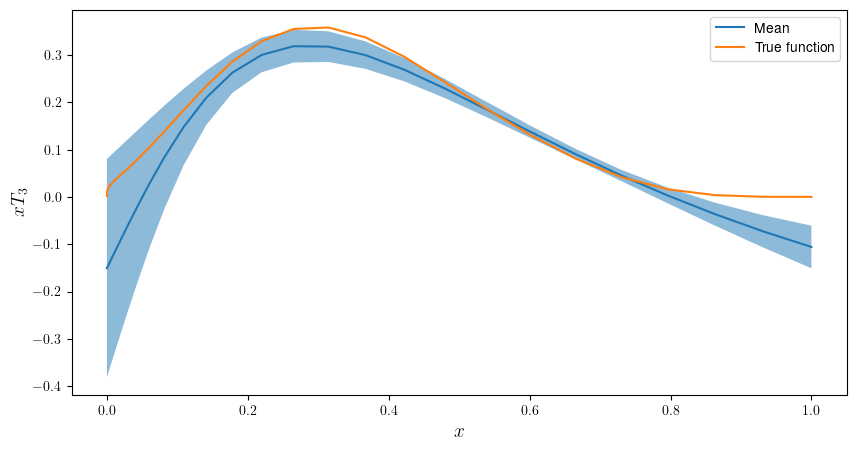

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(fk_grid, xT3_training.get_mean(), label='Mean')
plt.fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), alpha=0.5)
plt.plot(fk_grid, f_bcdms, label='True function')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$xT_3$', fontsize=14)
plt.legend()
plt.show()
if SAVE_PLOT:
  plt.savefig(PLOT_FOLDER / 'pdf_mean_std.png', dpi=300)
plt.close()

In [10]:
# Collect NTK distributions for each replica
if not any(SERIALIZATION_FOLDER.iterdir()):
  print('Data have not been serialized yet. Serializing now...')
  NTK_time = []
  frob_norm_time = []
  l2_norm_time = []
  linf_norm_time = []
  for epoch in common_epochs:
    print(f"Epoch {epoch} / {common_epochs[-1]}")
    NTK_distribution = Distribution(f'NTK epoch {epoch}') # Each epoch contains a distribution of NTKs
    frob_norm_dist = Distribution(f'Frobenius norm epoch {epoch}')
    l2_norm_dist = Distribution(f'L2 norm epoch {epoch}')
    linf_norm_dist = Distribution(f'Linf norm epoch {epoch}')
    for replica_path in replicas_folders:
      model = PDFmodel.load_model(replica_path / 'config.json', replica_path / select_weight(epoch))
      NTK = model.compute_ntk()
      _, S, _ = np.linalg.svd(NTK, hermitian=True)
      frob_norm_dist.add(np.sqrt(np.sum([s**2 for s in S])))
      l2_norm_dist.add(S[0])
      linf_norm_dist.add(np.linalg.norm(NTK, ord='inf'))
      NTK_distribution.add(NTK)

    NTK_time.append(NTK_distribution)
    frob_norm_time.append(frob_norm_dist)
    l2_norm_time.append(l2_norm_dist)
    linf_norm_time.append(linf_norm_dist)
    pickle.dump(NTK_time, open(SERIALIZATION_FOLDER / 'NTK_time.pickle', 'wb'))
    pickle.dump(frob_norm_time, open(SERIALIZATION_FOLDER / 'frob_norm_time.pickle', 'wb'))
    pickle.dump(l2_norm_time, open(SERIALIZATION_FOLDER / 'l2_norm_time.pickle', 'wb'))
    pickle.dump(linf_norm_time, open(SERIALIZATION_FOLDER / 'linf_norm_time.pickle', 'wb'))
else:
  print('Data have already been serialized. Loading from disk...')
  NTK_time = pickle.load(open(SERIALIZATION_FOLDER / 'NTK_time.pickle', 'rb'))
  frob_norm_time = pickle.load(open(SERIALIZATION_FOLDER / 'frob_norm_time.pickle', 'rb'))
  l2_norm_time = pickle.load(open(SERIALIZATION_FOLDER / 'l2_norm_time.pickle', 'rb'))
  linf_norm_time = pickle.load(open(SERIALIZATION_FOLDER / 'linf_norm_time.pickle', 'rb'))
  print('Done!')

Data have already been serialized. Loading from disk...
Done!


In [11]:
# Compute  \Delta\Theta_t = || \Theta_{t+1} - \Theta_t}||
Delta_ntk_t = []
for i in range(len(NTK_time) - 1):
  delta_ntk_dist = Distribution(f'Delta NTK {i}')
  for rep in range(replicas):
    delta_ntk = np.linalg.norm(NTK_time[i + 1][rep] - NTK_time[i][rep])
    delta_ntk_dist.add(delta_ntk)
  Delta_ntk_t.append(delta_ntk_dist)

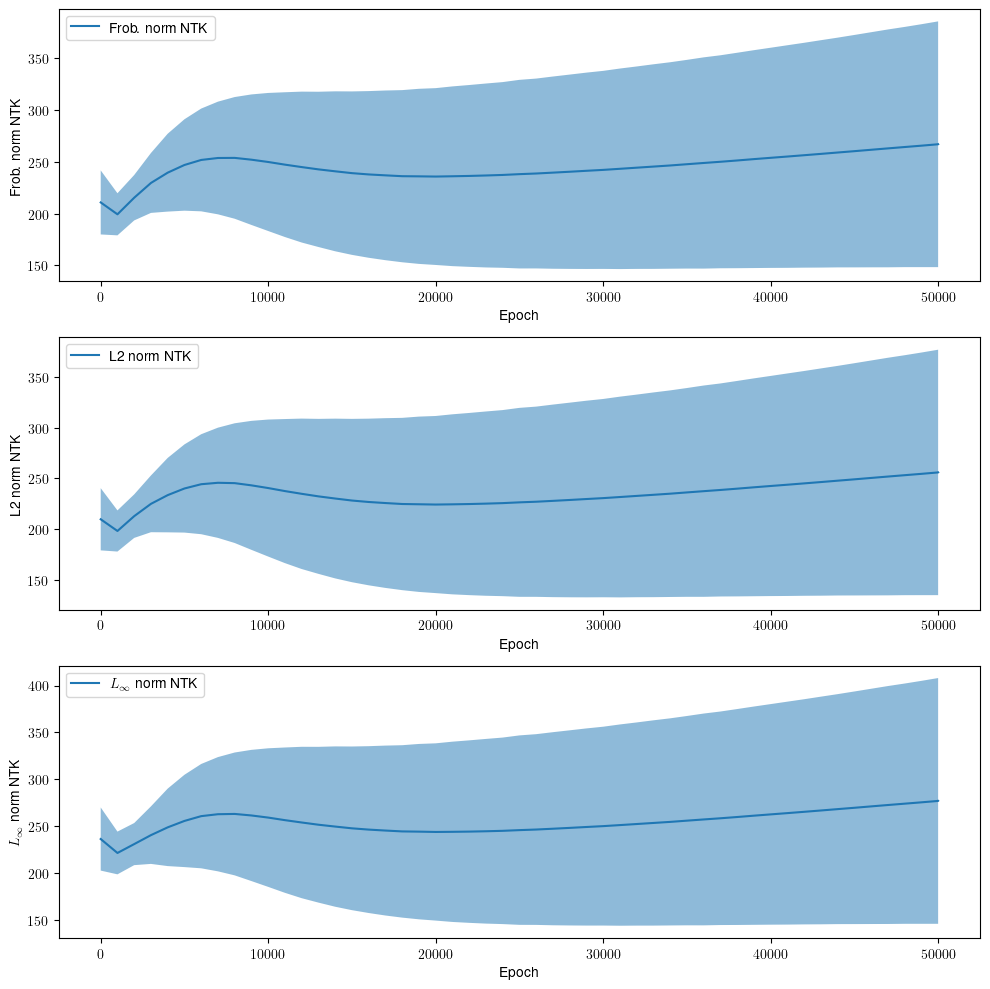

In [12]:
frob_means = np.array([frob.get_mean() for frob in frob_norm_time])
frob_stds = np.array([frob.get_std() for frob in frob_norm_time])
l2_means = np.array([l2.get_mean() for l2 in l2_norm_time])
l2_stds = np.array([l2.get_std() for l2 in l2_norm_time])
linf_means = np.array([linf.get_mean() for linf in linf_norm_time])
linf_stds = np.array([linf.get_std() for linf in linf_norm_time])

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

axs[0].plot(common_epochs, frob_means, label='Frob. norm NTK')
axs[0].fill_between(common_epochs, frob_means + frob_stds, frob_means - frob_stds, alpha=0.5)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Frob. norm NTK')
axs[0].legend()

axs[1].plot(common_epochs, l2_means, label='L2 norm NTK')
axs[1].fill_between(common_epochs, l2_means + l2_stds, l2_means - l2_stds, alpha=0.5)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('L2 norm NTK')
axs[1].legend()

axs[2].plot(common_epochs, linf_means, label=r'$L_{\infty}$ norm NTK')
axs[2].fill_between(common_epochs, linf_means + linf_stds, linf_means - linf_stds, alpha=0.5)
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel(r'$L_{\infty}$ norm NTK')
axs[2].legend()

fig.tight_layout()
if SAVE_PLOT:
  fig.savefig(PLOT_FOLDER / 'NTK_norms.png', dpi=300)

/var/folders/l5/l1kl3n_11gx3zm7b0wxctqym0000gn/T/ipykernel_34124/3573048809.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


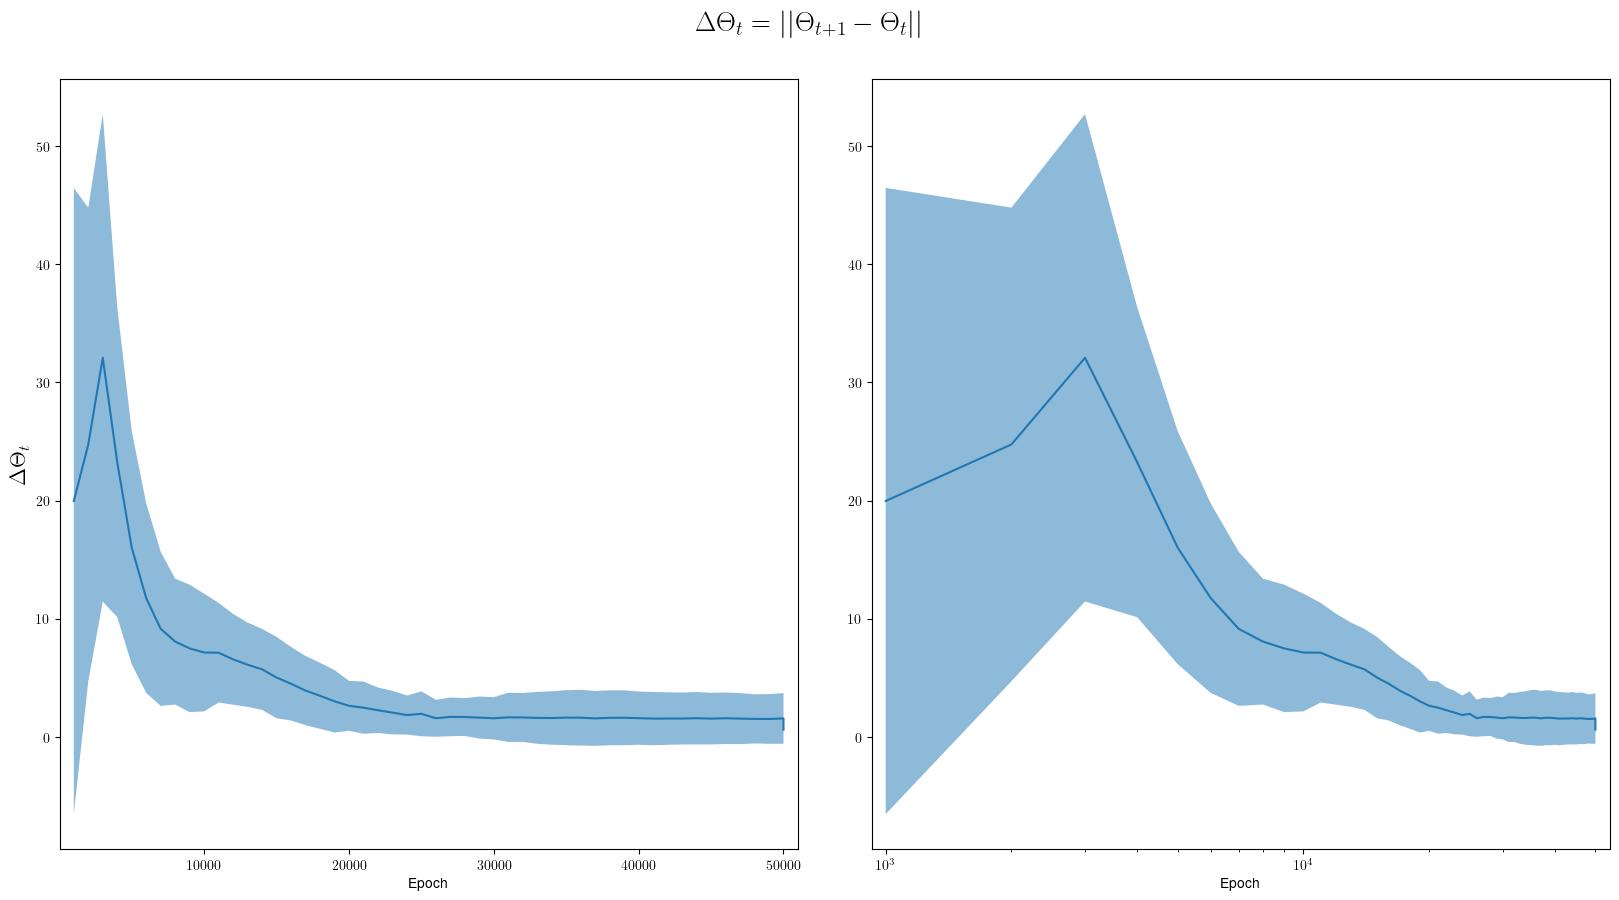

In [13]:
delta_ntk_means = np.array([delta.get_mean() for delta in Delta_ntk_t])
delta_ntk_stds = np.array([delta.get_std() for delta in Delta_ntk_t])

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

axs[0].plot(common_epochs[1:], delta_ntk_means, label='')
axs[0].fill_between(common_epochs[1:], delta_ntk_means + delta_ntk_stds, delta_ntk_means - delta_ntk_stds, alpha=0.5)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel(r'$\Delta \Theta_t$', fontsize=16)
axs[0].set_xmargin(0.02)

axs[1].plot(common_epochs[1:], delta_ntk_means, label='')
axs[1].fill_between(common_epochs[1:], delta_ntk_means + delta_ntk_stds, delta_ntk_means - delta_ntk_stds, alpha=0.5)
axs[1].set_xlabel('Epoch')
axs[1].set_xscale('log')
axs[1].set_xmargin(0.02)

fig.suptitle(r'$\Delta \Theta_t = || \Theta_{t+1} - \Theta_{t}||$', fontsize=20, y=0.95)
fig.tight_layout()
if SAVE_PLOT:
  fig.savefig(PLOT_FOLDER / 'delta_ntk.png', dpi=300)

# Integrating the gradient flow

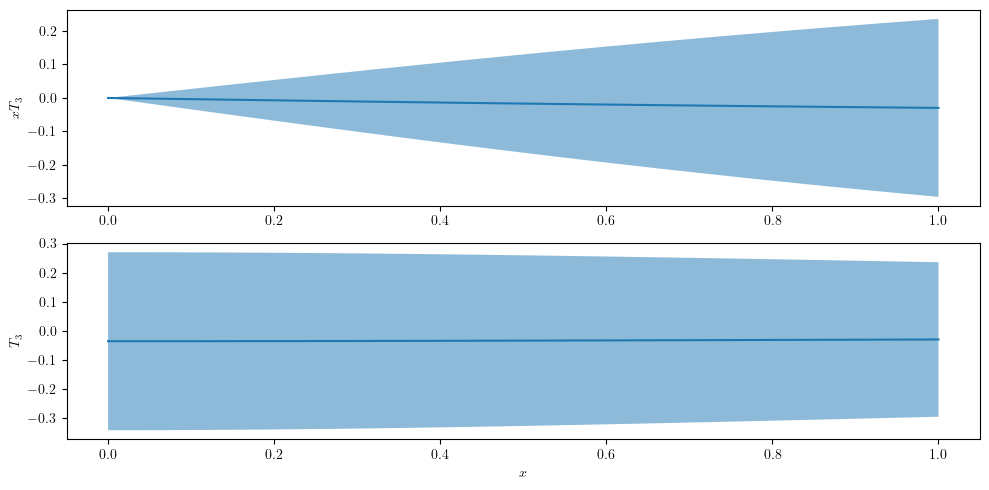

In [14]:
# Generating and ensemble of models
replicas = len(replicas_folders)
seed = 1423413
xT3_0 = Distribution('xT3 at initialisation')
T3_0 = Distribution('T3 at initialisation')
for rep in range(replicas):
  model = PDFmodel(
          dense_layer='Dense',
          input=fk_grid,
          outputs=1,
          architecture=[28,20],
          activations=['tanh', 'tanh'],
          kernel_initializer='GlorotNormal',
          user_ki_args=None,
          seed=seed + rep)

  xT3_0.add(model.predict().numpy().reshape(-1))
  T3_0.add(model.predict().numpy().reshape(-1) / fk_grid)


# Plot the distribution at initialisation
fig, axs = plt.subplots(2,1, figsize=(10, 5))
axs[0].plot(fk_grid, xT3_0.get_mean(), label='Mean')
axs[0].fill_between(fk_grid, xT3_0.get_mean()  - xT3_0.get_std(), xT3_0.get_mean() + xT3_0.get_std(), alpha=0.5)
axs[0].set_ylabel(r'$xT_3$')

axs[1].plot(fk_grid, T3_0.get_mean(), label='Mean')
axs[1].fill_between(fk_grid, T3_0.get_mean()  - T3_0.get_std(), T3_0.get_mean() + T3_0.get_std(), alpha=0.5)
axs[1].set_ylabel(r'$T_3$')
axs[1].set_xlabel(r'$x$')
#_ = plt.title('Distribution at initialisation')

fig.tight_layout()
if SAVE_PLOT:
  fig.savefig(PLOT_FOLDER / 'initialisation_distribution.png', dpi=300)

In [15]:
if APPLY_LIM_KIN:
  # append kinematic limit to the fk tables
  limkin = np.zeros_like(fk_grid)
  limkin[-1] = 1.0
  data_by_replica = Distribution("Data replicas with kinematic limit")
  for rep in range(replicas):
    data_by_replica.add(np.concatenate([data_by_replica_original[rep], [0.0]]))
  Cykin = np.pad(Cy, ((0, 1), (0, 1)), mode='constant', constant_values=0)
  Cykin[-1, -1] = 1.e-6
  Cinv = np.linalg.inv(Cykin)
  FK = np.vstack([FK_original, limkin])

else:
  FK = FK_original
  Cinv = np.linalg.inv(Cy)
  data_by_replica = data_by_replica_original

In [16]:
M = FK.T @ Cinv @ FK

Vl, sigma, Vr_T = np.linalg.svd(M, hermitian=True)
V = Vl

print('The first rank-order at which right- and left-singular vectors are different is: ', end='')
for r_idx in range(Vl.shape[0]):
  if not np.allclose(Vl[:,r_idx], Vr_T.T[:,r_idx]):
    print(f"{r_idx}")
    break

The first rank-order at which right- and left-singular vectors are different is: 22


In [17]:
from collections import namedtuple
from functools import lru_cache

info_by_replica = namedtuple('info_by_replica', ['h', 'W', 'B', 'Z_perp', 'Z_par'])

@lru_cache(maxsize=None)  # maxsize=None means unlimited cache size
def collect_by_replica(reference_epoch, initial_dist, fluctuate_ntk=True, fluctuate_data=True):

  # Compute H_tilde from the decomposition of M0
  epoch_index = np.argwhere(np.array(common_epochs) == reference_epoch)
  if len(epoch_index) == 0:
    raise ValueError(f"Epoch {reference_epoch} does not exist.")
  
  ntk_dist = NTK_time[epoch_index[0,0]] # Choose the last common epoch for the NTK
  W_by_replica = []
  B_by_replica = []
  h_by_replica = []
  Z_perp_by_replica = []
  Z_par_by_replica = []
  tol = 9.e-7

  if not fluctuate_ntk:
    ntk = ntk_dist.get_mean(axis=0)
  
  if not fluctuate_data:
    Y = data_by_replica.get_mean(axis=0)
  
  for rep in range(replicas):
    
    if fluctuate_ntk:
      ntk = ntk_dist[rep]
    
    if fluctuate_data:
      Y = data_by_replica[rep]

    Z, Lambda, ZrT = np.linalg.svd(ntk, hermitian=True)
    sorted_indices = np.argsort(Lambda)[::-1]
    Lambda = Lambda[sorted_indices]
    Z = Z[:, sorted_indices]

    for idx in range(len(Lambda)):
      if not np.allclose(Z[:,idx], ZrT.T[:,idx]):
        #print(f"The first rank-order at which right- and left-singular vectors are different is: {idx}")
        cut = int(idx * 0.66)
        break
    
    Lambda = np.diag([lambd if idx < cut else 0 for idx, lambd in enumerate(Lambda)])
    Lambda_perp = Lambda[:cut, :cut]
    Z_perp = Z[:,:cut]
    Z_par = Z[:,cut:]

    H_perp = Lambda_perp @ Z_perp.T @ M @ Z_perp
    B = Lambda_perp @ ( -Z_perp.T @ M @ Z_par @ Z_par.T @ initial_dist[rep] + Z_perp.T @ FK.T @ Cinv @ Y)
    h, Winv = np.linalg.eig(H_perp)
    sorted_indices = np.argsort(h)[::-1]
    h = h[sorted_indices]
    Winv = Winv[:, sorted_indices]
    W = np.linalg.inv(Winv)

    B_by_replica.append(B)
    Z_perp_by_replica.append(Z_perp)
    Z_par_by_replica.append(Z_par)
    W_by_replica.append(W)
    h_by_replica.append(h)

    if ASSERT:

      # ========== CHECK PROJECTORS =====================================
      f0 = (Z_perp @ Z_perp.T + Z_par @ Z_par.T) @ initial_dist[rep]
      try:
        assert np.allclose(f0, initial_dist[rep], atol=tol)
      except AssertionError:
        print(f"Replica {rep} failed the check. Checking element-wise...")
        for idx in range(len(f0)):
          if not np.isclose(f0[idx], initial_dist[rep][idx]):
            print(f"Element {idx} failed the check: {f0[idx]} != {initial_dist[rep][idx]}")
        raise AssertionError("The decomposition is not correct")

      # ============ CHECK DECOMPOSITION =================================
      assert np.allclose(Winv @ np.diag(h) @ np.linalg.inv(Winv), H_perp)

      # ========== CHECK W @ Winv ========================================
      assert np.allclose(W @ Winv, np.eye(W.shape[0]))
      assert np.allclose(Winv @ W, np.eye(W.shape[0]))
      assert np.allclose(np.linalg.inv(H_perp), Winv @ np.diag(1/h) @ W)
      
      # ============ CHECK POSITIVE h ====================================
      try:
        assert np.any(h > 0.0)
      except AssertionError:
        print("Eigenvalues are not positive")
        print(f"h: {h}")

      # ============ CHECK SUBMATRIX OF H MATCHES Hperp ==================
      H = Lambda @ Z.T @ M @ Z
      try:
        assert np.allclose(H[:cut, :cut], H_perp)
      except AssertionError:
        print(f"Submatrix of H does not match Hperp for replica {rep}")
        print(f"Submatrix of H:\n {H[:cut, :cut]}")
        print(f"Hperp:\n {H_perp}")
        raise AssertionError("Submatrix of H does not match Hperp.")
      
      # ============ CHECK H_perp and H_tilde ===========================
      H_tilde = np.sqrt(np.diag(sigma)) @ V.T @ Z @ Lambda @ Z.T @ V @ np.sqrt(np.diag(sigma))
      h_test, _ = np.linalg.eig(H_tilde)
      h_test = h_test.real

      # Ensure h_test is in descending order
      if not np.all(h_test[:-1] >= h_test[1:]):  # Check if not in descending order
        h_test = np.sort(h_test)[::-1]  # Sort in descending order
      try:
        assert np.allclose(h, h_test[:cut])
      except AssertionError:
        print(f"Eigenvalues of H and Htilde are not the same for replica {rep}")
        print(f"Eigenvalues of Hperp:\n {h}")
        print(f"Eigenvalues of Htilde:\n {h_test[:cut]}")
        raise AssertionError("Eigenvalues of H and Htilde are not the same.")
      
  result = info_by_replica(
    h=h_by_replica,
    W=W_by_replica,
    B=B_by_replica,
    Z_perp=Z_perp_by_replica,
    Z_par=Z_par_by_replica
  )
  return result

In [18]:
def compute_evolution_t(evolution_time, initial_dist, reference_epoch, fluctuate_ntk, fluctuate_data):
  res = Distribution(f'Solution at epoch {evolution_time}')
  collection_by_replica = collect_by_replica(reference_epoch, initial_dist=initial_dist, fluctuate_ntk=fluctuate_ntk, fluctuate_data=fluctuate_data)

  for rep in range(replicas):
    h = collection_by_replica.h[rep]
    W = collection_by_replica.W[rep]
    B = collection_by_replica.B[rep]
    Z_perp = collection_by_replica.Z_perp[rep]
    Zpar = collection_by_replica.Z_par[rep]

    Winv = np.linalg.inv(W)
    F0 = W @ Z_perp.T @ initial_dist[rep]
    WB = W @ B
    
    Ft = np.array(
     [
       np.exp(-h[i] * evolution_time) * F0[i] + (1 - np.exp(-h[i] * evolution_time)) * WB[i] / h[i] for i in range(h.size)
    ])

    ft = Z_perp @ Winv @ Ft + Zpar @ Zpar.T @ initial_dist[rep]
    res.add(ft)
  return res

In [19]:
def compute_evolution_inf(initial_dist, reference_epoch, fluctuate_ntk, fluctuate_data):
  res = Distribution('Solution at infinity')
  collection_by_replica = collect_by_replica(reference_epoch, initial_dist=initial_dist, fluctuate_ntk=fluctuate_ntk, fluctuate_data=fluctuate_data)

  for rep in range(replicas):
    h = collection_by_replica.h[rep]
    W = collection_by_replica.W[rep]
    B = collection_by_replica.B[rep]
    Z_perp = collection_by_replica.Z_perp[rep]
    Zpar = collection_by_replica.Z_par[rep]

    Winv = np.linalg.inv(W)
    WB = W @ B
    
    Ft = np.array([WB[i] / h[i] for i in range(h.size)])

    ft = Z_perp @ Winv @ Ft + Zpar @ Zpar.T @ initial_dist[rep]
    res.add(ft)
  return res

# Check analytical solution at initialisation

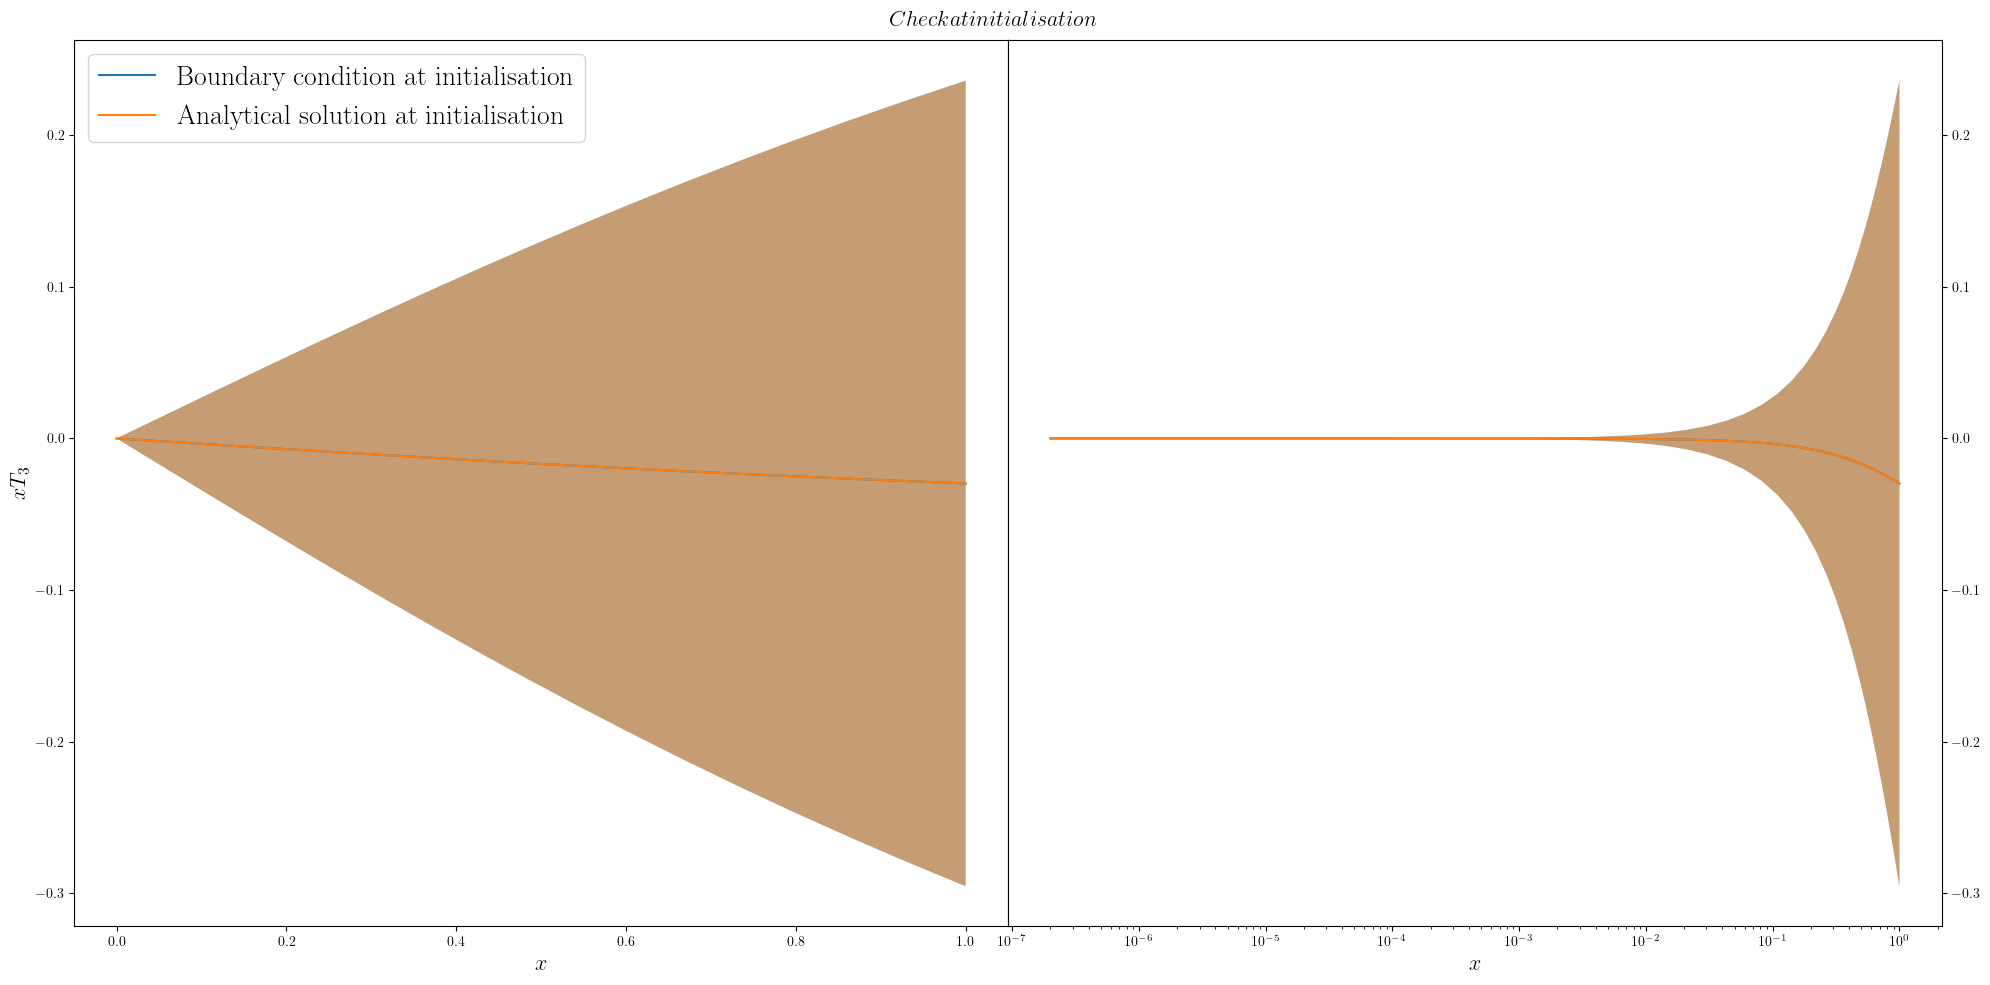

In [20]:
# Check solution at t = 0

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})
xT3_t = compute_evolution_t(0.0, xT3_0, 50001, True, True)

# xf linaer
axs[0].plot(fk_grid, xT3_0.get_mean(), label=r'$\textrm{Boundary condition at initialisation}$')
axs[0].fill_between(fk_grid, xT3_0.get_mean() - xT3_0.get_std(), xT3_0.get_mean() + xT3_0.get_std(), alpha=0.5)
axs[0].plot(fk_grid, xT3_t.get_mean(), label=r'$\textrm{Analytical solution at initialisation}$')
axs[0].fill_between(fk_grid, xT3_t.get_mean() - xT3_t.get_std(), xT3_t.get_mean() + xT3_t.get_std(), alpha=0.5)

# xf log
axs[1].plot(fk_grid, xT3_0.get_mean())
axs[1].fill_between(fk_grid, xT3_0.get_mean() - xT3_0.get_std(), xT3_0.get_mean() + xT3_0.get_std(), alpha=0.5)
axs[1].plot(fk_grid, xT3_t.get_mean())
axs[1].fill_between(fk_grid, xT3_t.get_mean() - xT3_t.get_std(), xT3_t.get_mean() + xT3_t.get_std(), alpha=0.5)
axs[1].set_xscale('log')
axs[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)


axs[0].set_ylabel(r'$xT_3$', fontsize=16)
axs[0].set_xlabel(r'$x$', fontsize=16)
axs[1].set_xlabel(r'$x$', fontsize=16)

axs[0].legend(fontsize=20)

fig.suptitle(r'${Check at initialisation}$', fontsize=16)
fig.tight_layout()

# Check solution at infinity

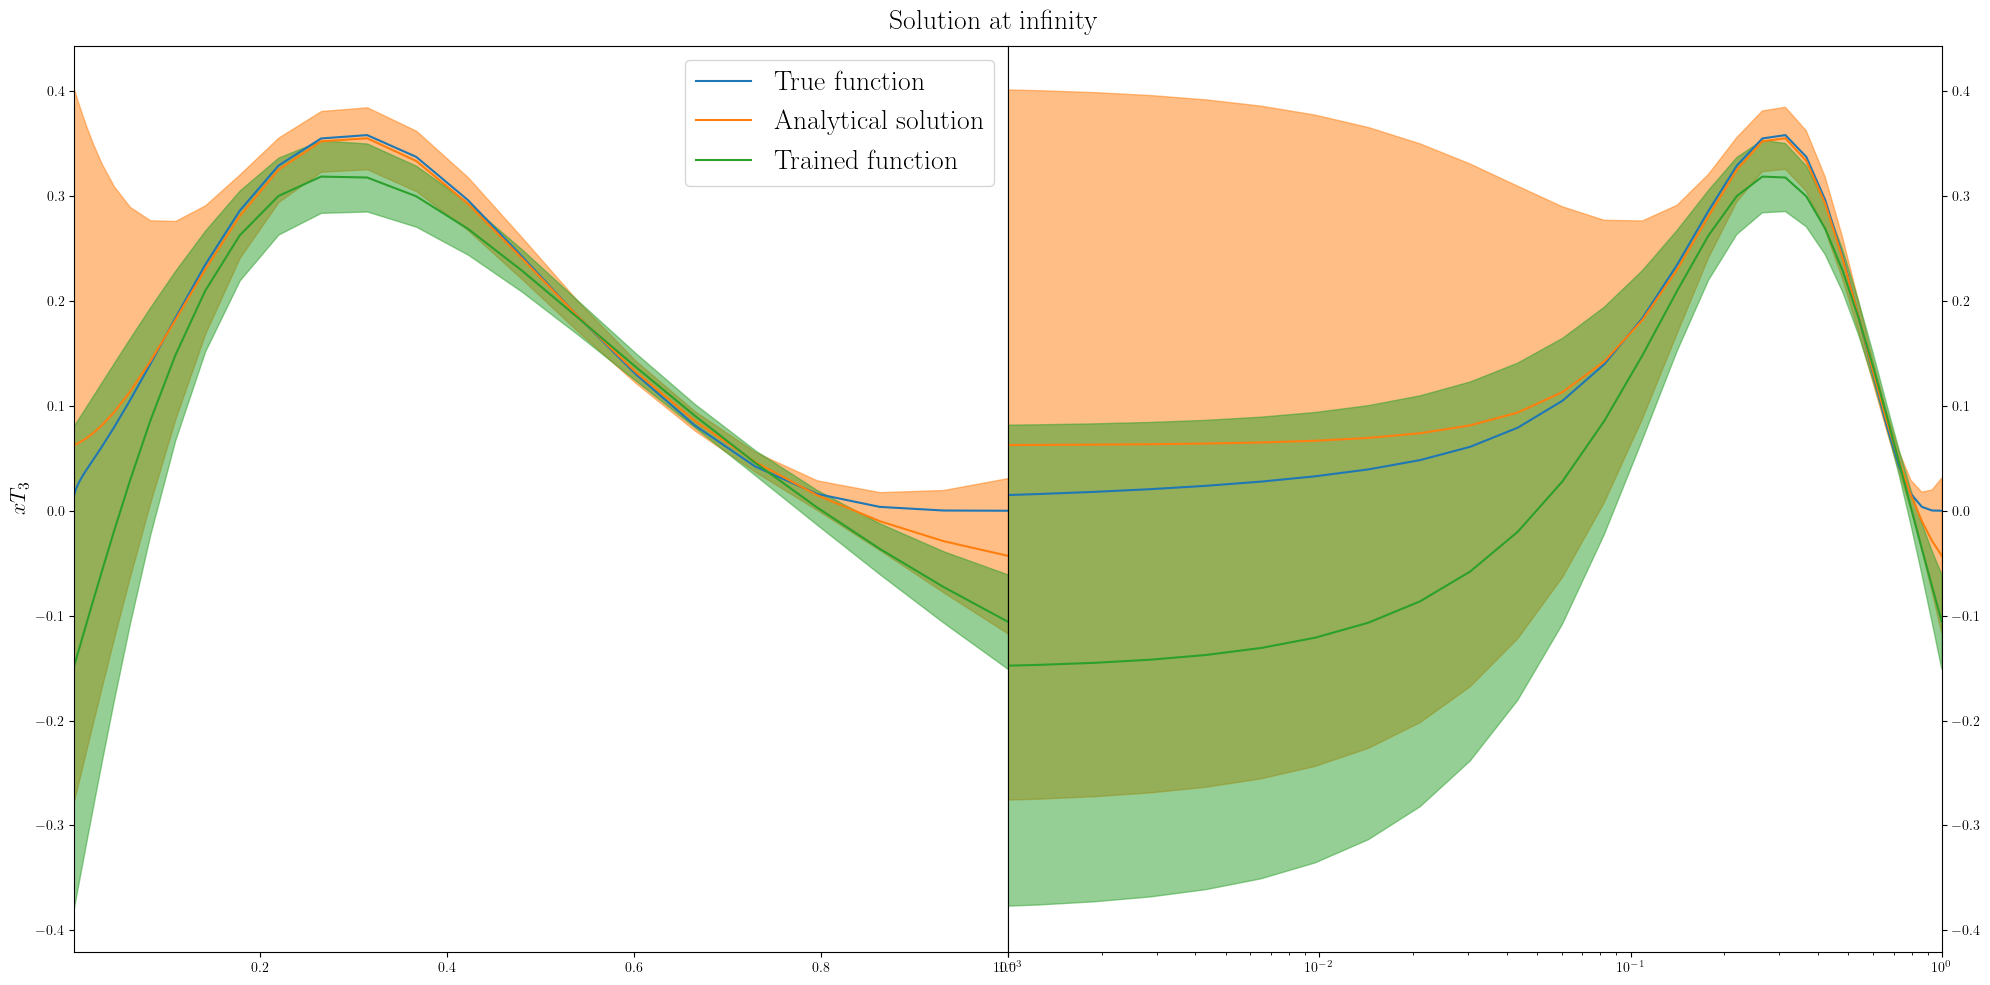

In [21]:
# Check solution at infinity
xT3_inf = compute_evolution_inf(xT3_0, 50001, True, True)

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})

#=====================================================================
# True function
axs[0].plot(fk_grid, f_bcdms, color='C0', label=r'$\textrm{True function}$')

# Analytical solution
axs[0].plot(fk_grid, xT3_inf.get_mean(), color='C1', label=r'$\textrm{Analytical solution}$')
axs[0].fill_between(fk_grid, xT3_inf.get_mean() - xT3_inf.get_std(), xT3_inf.get_mean() + xT3_inf.get_std(), alpha=0.5, color='C1')

# Trained solution
axs[0].plot(fk_grid, xT3_training.get_mean(), color='C2', label=r'$\textrm{Trained function}$')
axs[0].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), alpha=0.5, color='C2')

axs[0].set_ylabel(r'$xT_3$', fontsize=16)
axs[0].legend(fontsize=20)
axs[0].set_xlim(1.e-3, 1)
axs[0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False)

#=====================================================================
axs[1].plot(fk_grid, f_bcdms, color='C0')

axs[1].plot(fk_grid, xT3_inf.get_mean(), color='C1')
axs[1].fill_between(fk_grid, xT3_inf.get_mean() - xT3_inf.get_std(), xT3_inf.get_mean() + xT3_inf.get_std(), alpha=0.5, color='C1')

axs[1].plot(fk_grid, xT3_training.get_mean(), color='C2')
axs[1].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), alpha=0.5, color='C2')

axs[1].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False)
axs[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)
axs[1].set_xlim(1.e-3, 1)
axs[1].set_xscale('log')

fig.suptitle(r'$\textrm{Solution at infinity}$', fontsize=20)
fig.tight_layout()
if SAVE_PLOT:
  fig.savefig(PLOT_FOLDER / 'xT3_infinity.png', dpi=300)

# 1) Analytical solution with random initialisation and ntk from last training epoch

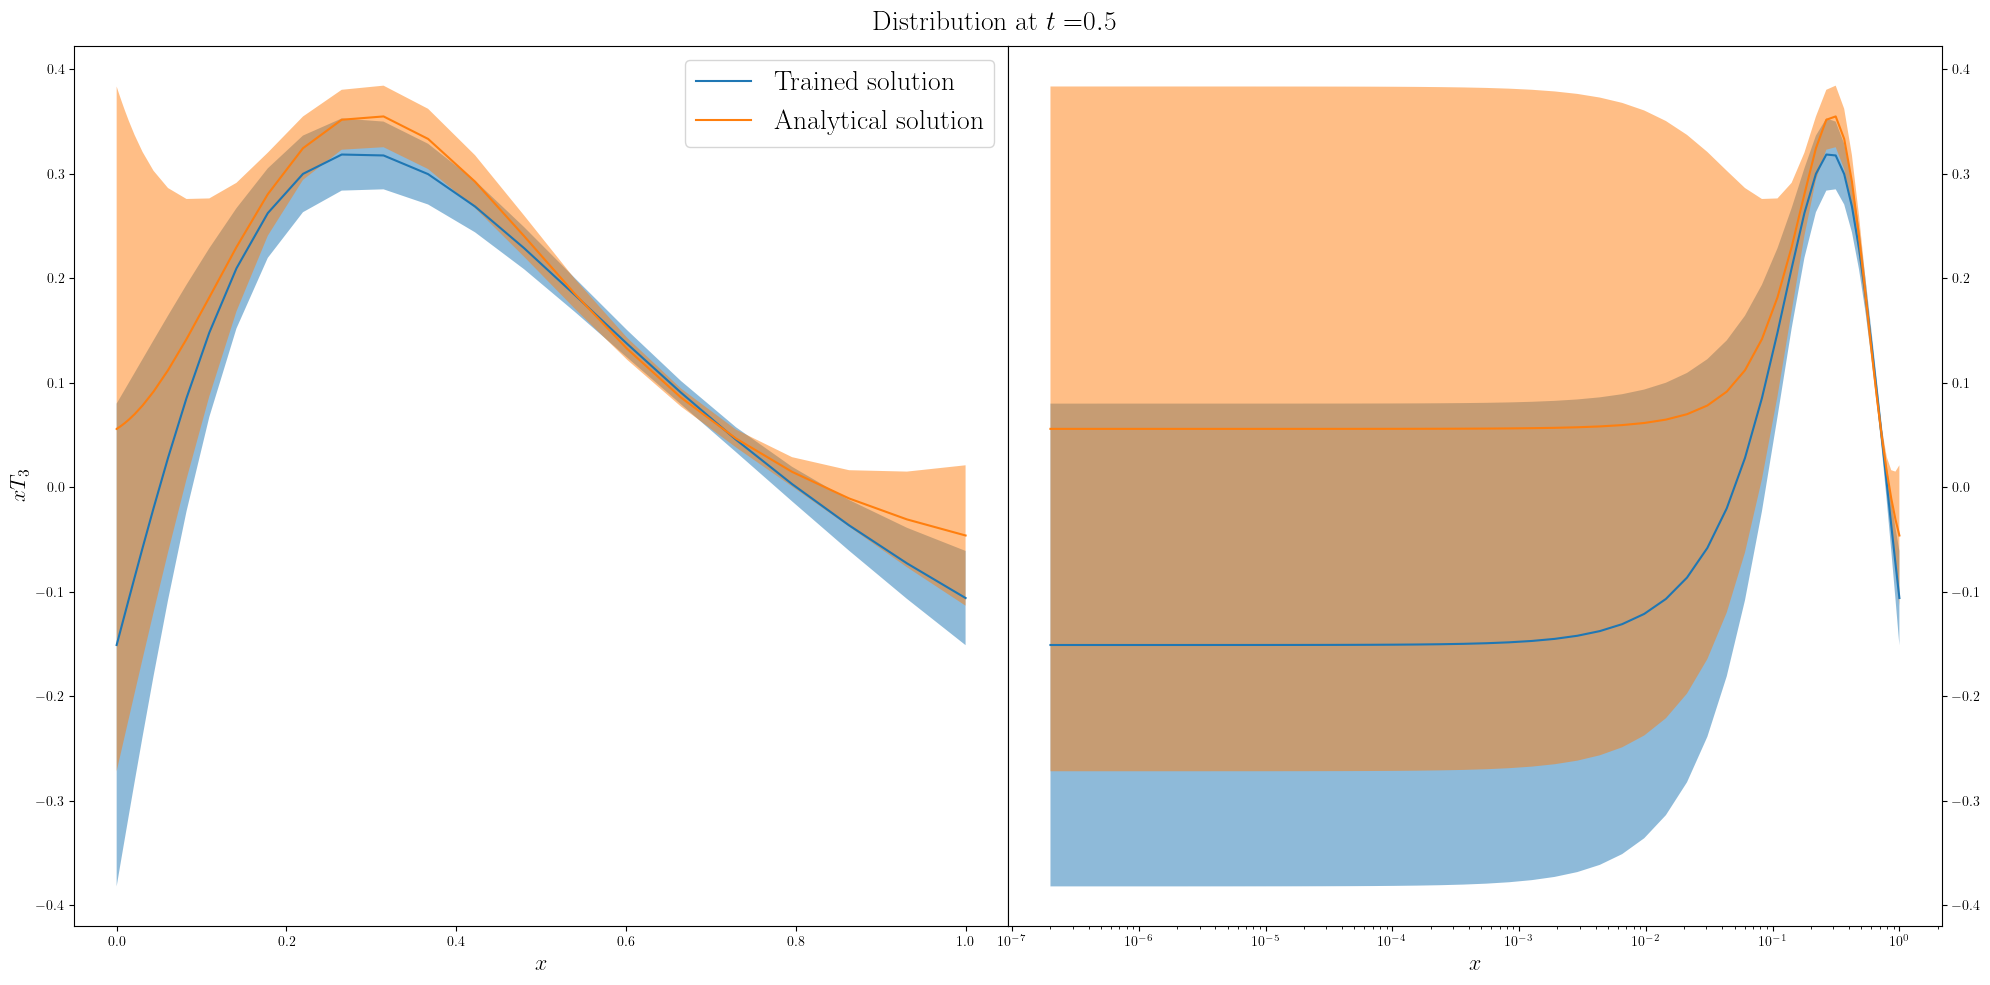

In [22]:
# Check solution at t = 0
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})
t=0.5
xT3_t = compute_evolution_t(t, xT3_0, 50001, True, True)

# xf linaer
axs[0].plot(fk_grid, xT3_training.get_mean(), label=r'$\textrm{Trained solution}$')
axs[0].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), alpha=0.5)
axs[0].plot(fk_grid, xT3_t.get_mean(), label=r'$\textrm{Analytical solution}$')
axs[0].fill_between(fk_grid, xT3_t.get_mean() - xT3_t.get_std(), xT3_t.get_mean() + xT3_t.get_std(), alpha=0.5)

# xf log
axs[1].plot(fk_grid, xT3_training.get_mean())
axs[1].fill_between(fk_grid, xT3_training.get_mean() - xT3_training.get_std(), xT3_training.get_mean() + xT3_training.get_std(), alpha=0.5)
axs[1].plot(fk_grid, xT3_t.get_mean())
axs[1].fill_between(fk_grid, xT3_t.get_mean() - xT3_t.get_std(), xT3_t.get_mean() + xT3_t.get_std(), alpha=0.5)
axs[1].set_xscale('log')
axs[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)


axs[0].set_ylabel(r'$xT_3$', fontsize=16)
axs[0].set_xlabel(r'$x$', fontsize=16)
axs[1].set_xlabel(r'$x$', fontsize=16)

axs[0].legend(fontsize=20)

fig.suptitle(r'$\textrm{Distribution at } t =$' + rf'${t}$', fontsize=20)
fig.tight_layout()
if SAVE_PLOT:
  fig.savefig(PLOT_FOLDER / 'xT3_1.png', dpi=300)

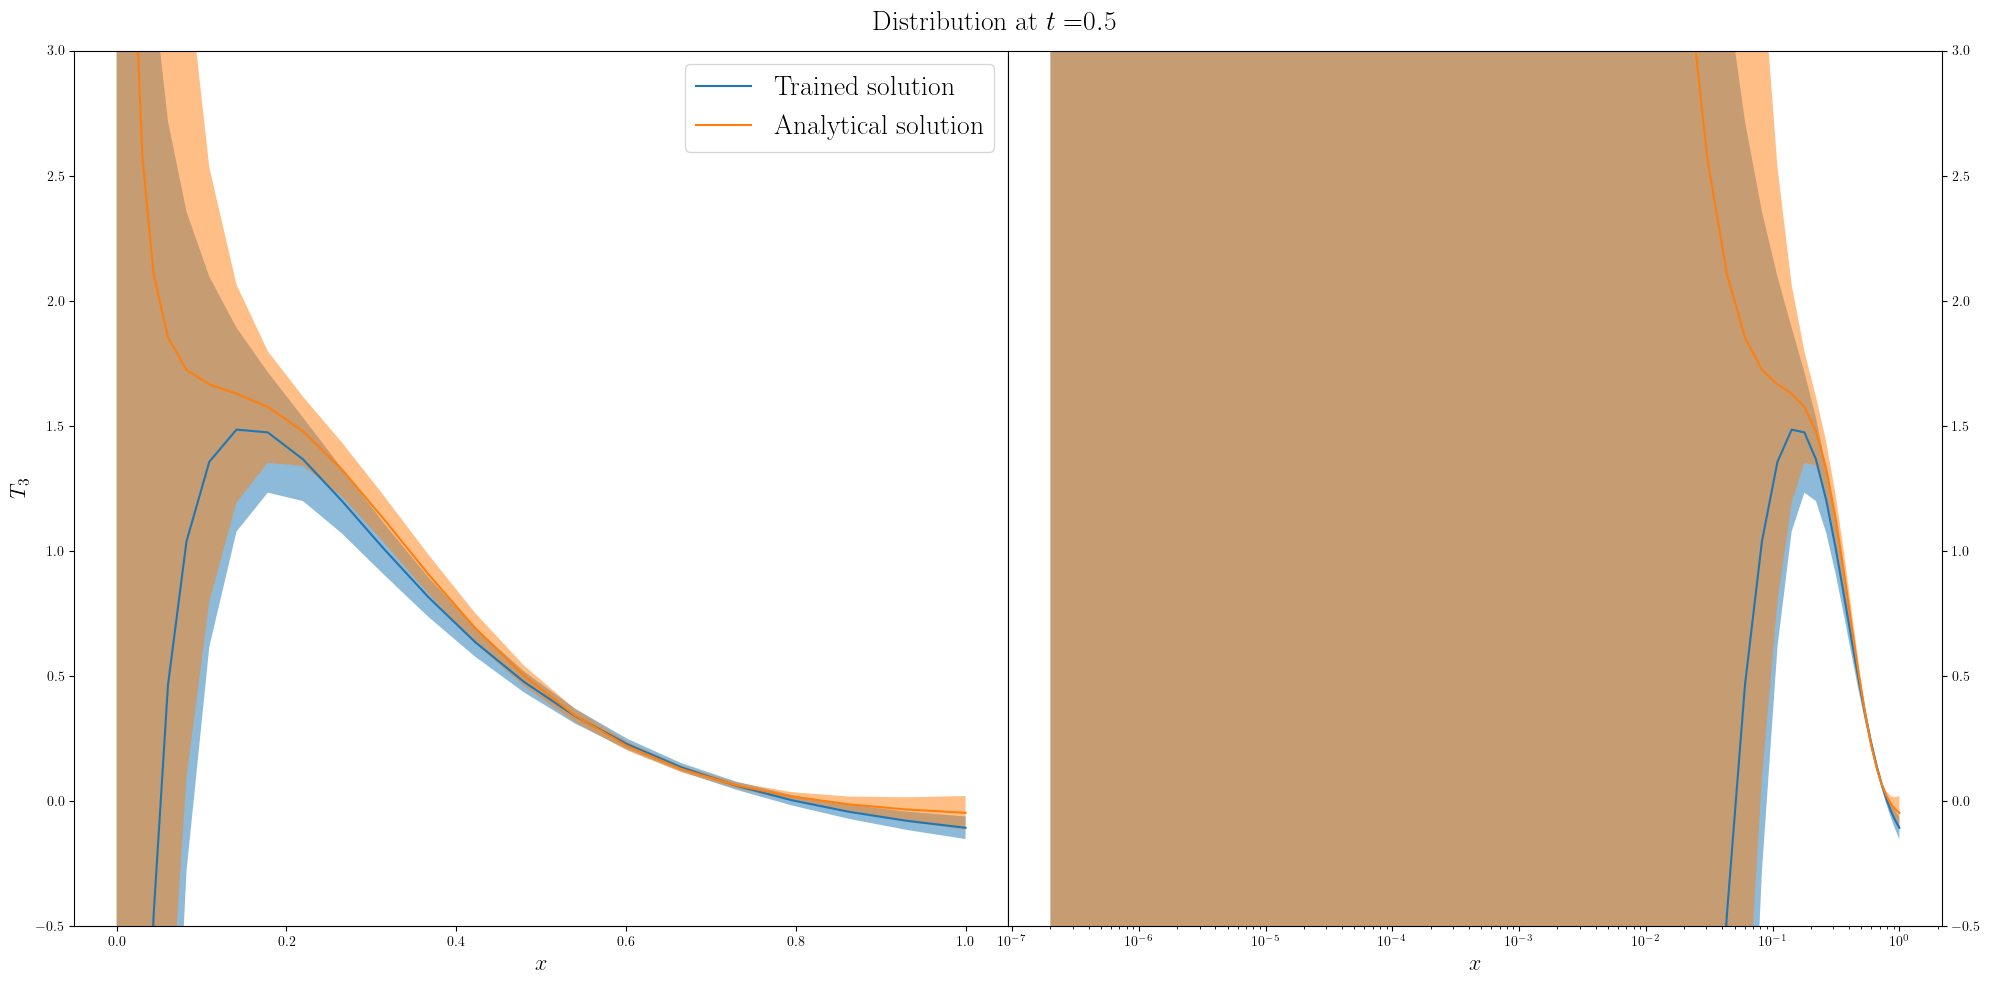

In [23]:
# Check solution at t = 0
fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})
T3_t = xT3_t.apply_operator(b=fk_grid, operator=lambda a, b: np.true_divide(a, b), axis=0, name=f'T3 at t={t}')

# xf linaer
axs[0].plot(fk_grid, T3_training.get_mean(), label=r'$\textrm{Trained solution}$')
axs[0].fill_between(fk_grid, T3_training.get_mean() - T3_training.get_std(), T3_training.get_mean() + T3_training.get_std(), alpha=0.5)
axs[0].plot(fk_grid, T3_t.get_mean(), label=r'$\textrm{Analytical solution}$')
axs[0].fill_between(fk_grid, T3_t.get_mean() - T3_t.get_std(), T3_t.get_mean() + T3_t.get_std(), alpha=0.5)

# xf log
axs[1].plot(fk_grid, T3_training.get_mean())
axs[1].fill_between(fk_grid, T3_training.get_mean() - T3_training.get_std(), T3_training.get_mean() + T3_training.get_std(), alpha=0.5)
axs[1].plot(fk_grid, T3_t.get_mean())
axs[1].fill_between(fk_grid, T3_t.get_mean() - T3_t.get_std(), T3_t.get_mean() + T3_t.get_std(), alpha=0.5)
axs[1].set_xscale('log')
axs[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)


axs[0].set_ylabel(r'$T_3$', fontsize=16)
axs[0].set_xlabel(r'$x$', fontsize=16)
axs[1].set_xlabel(r'$x$', fontsize=16)

axs[0].legend(fontsize=20)
axs[0].set_ylim(-0.5,3)
axs[1].set_ylim(-0.5,3)

fig.suptitle(r'$\textrm{Distribution at } t =$' + rf'${t}$', fontsize=20)
fig.tight_layout()
if SAVE_PLOT:
  fig.savefig(PLOT_FOLDER / 'T3_1.png', dpi=300)

# 2) Analytical solution with initial condition from training

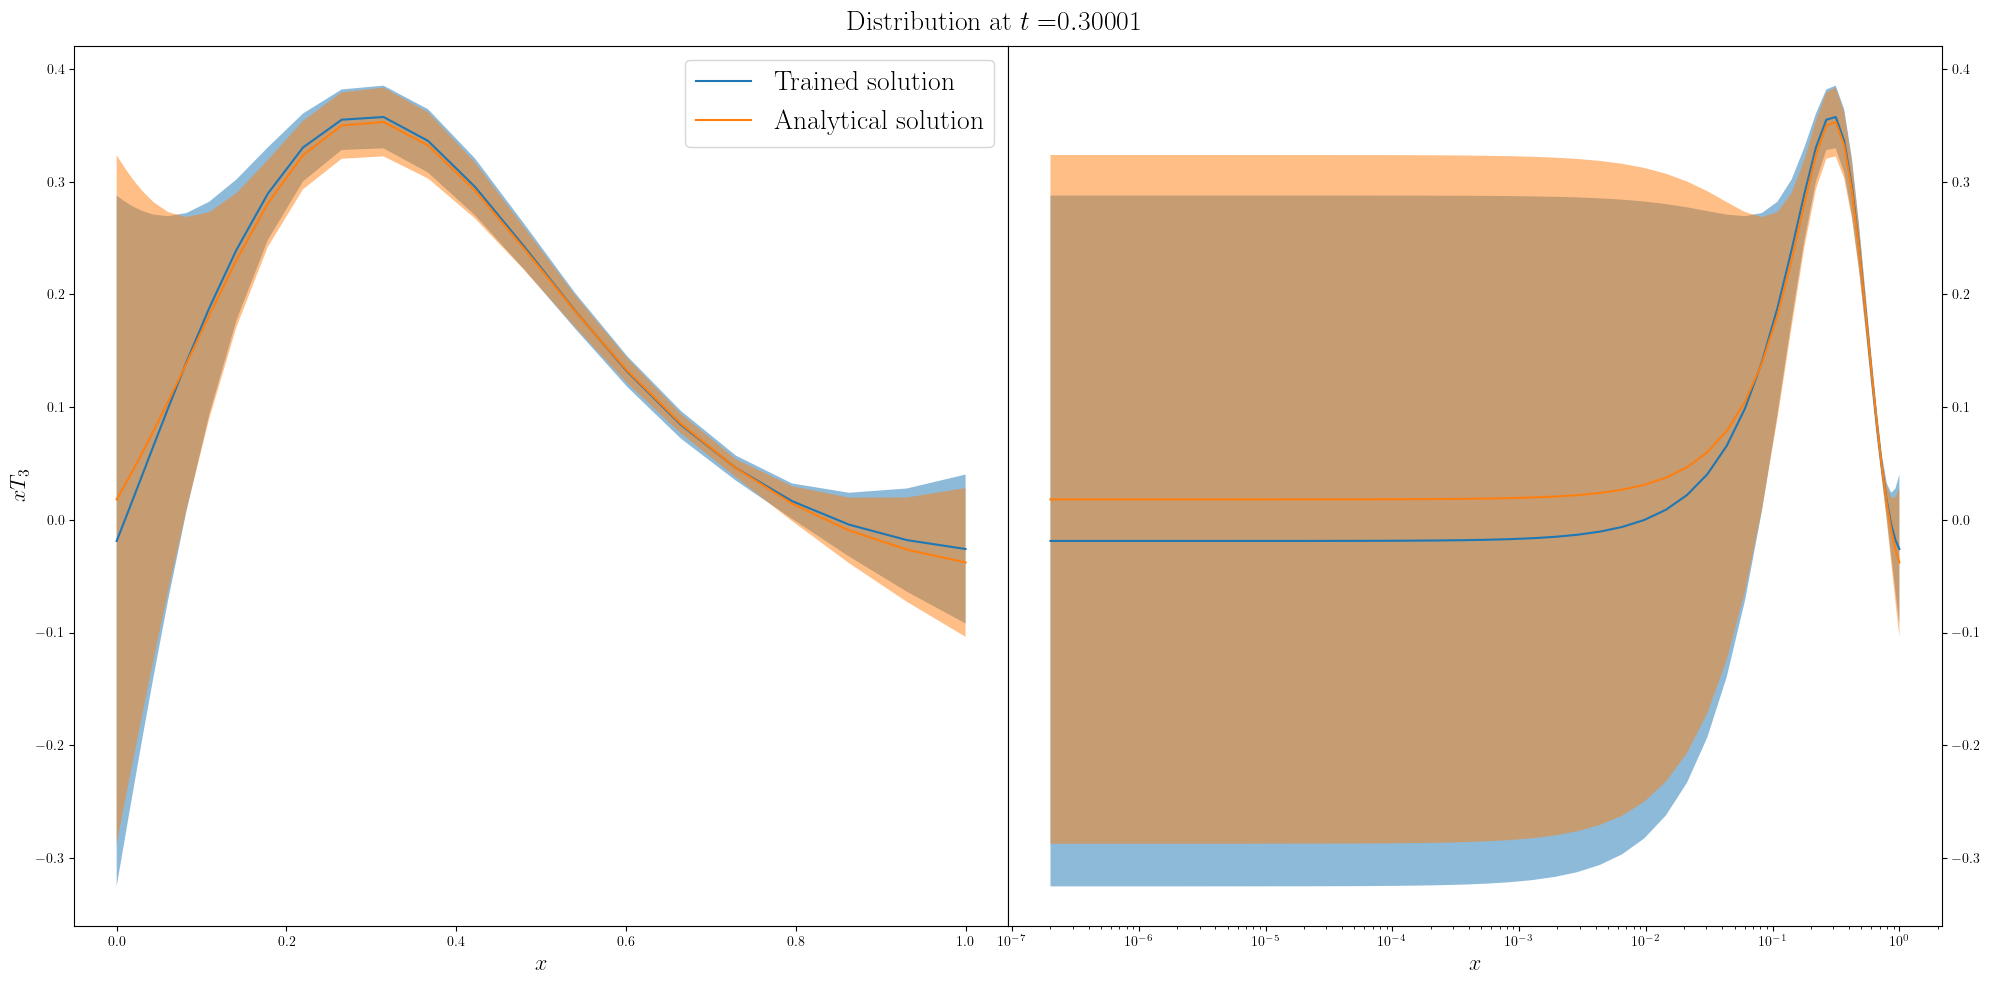

In [24]:
ref_epoch = 20000
xT3_ref = Distribution('xT3 at reference epoch')

for replica_path in replicas_folders:
    replica = replica_path.name
    last_epoch = replica_epochs_dict[replica][np.argwhere(np.array(common_epochs) == ref_epoch)[0,0]]

    model = PDFmodel.load_model(replica_path / 'config.json', last_epoch)
    xT3_ref.add(model.predict().numpy().reshape(-1))

t = (common_epochs[-1] - ref_epoch) * 1.e-5
xT3_t = compute_evolution_t(t, xT3_ref, ref_epoch, True, True)

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})

# xf linaer
axs[0].plot(fk_grid, xT3_ref.get_mean(), label=r'$\textrm{Trained solution}$')
axs[0].fill_between(fk_grid, xT3_ref.get_mean() - xT3_ref.get_std(), xT3_ref.get_mean() + xT3_ref.get_std(), alpha=0.5)
axs[0].plot(fk_grid, xT3_t.get_mean(), label=r'$\textrm{Analytical solution}$')
axs[0].fill_between(fk_grid, xT3_t.get_mean() - xT3_t.get_std(), xT3_t.get_mean() + xT3_t.get_std(), alpha=0.5)

# xf log
axs[1].plot(fk_grid, xT3_ref.get_mean())
axs[1].fill_between(fk_grid, xT3_ref.get_mean() - xT3_ref.get_std(), xT3_ref.get_mean() + xT3_ref.get_std(), alpha=0.5)
axs[1].plot(fk_grid, xT3_t.get_mean())
axs[1].fill_between(fk_grid, xT3_t.get_mean() - xT3_t.get_std(), xT3_t.get_mean() + xT3_t.get_std(), alpha=0.5)
axs[1].set_xscale('log')
axs[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)


axs[0].set_ylabel(r'$xT_3$', fontsize=16)
axs[0].set_xlabel(r'$x$', fontsize=16)
axs[1].set_xlabel(r'$x$', fontsize=16)

axs[0].legend(fontsize=20)

fig.suptitle(r'$\textrm{Distribution at } t =$' + rf'${t}$', fontsize=20)
fig.tight_layout()
if SAVE_PLOT:
  fig.savefig(PLOT_FOLDER / 'xT3_2.png', dpi=300)

# 3) As 2) fluctuating the initialization only

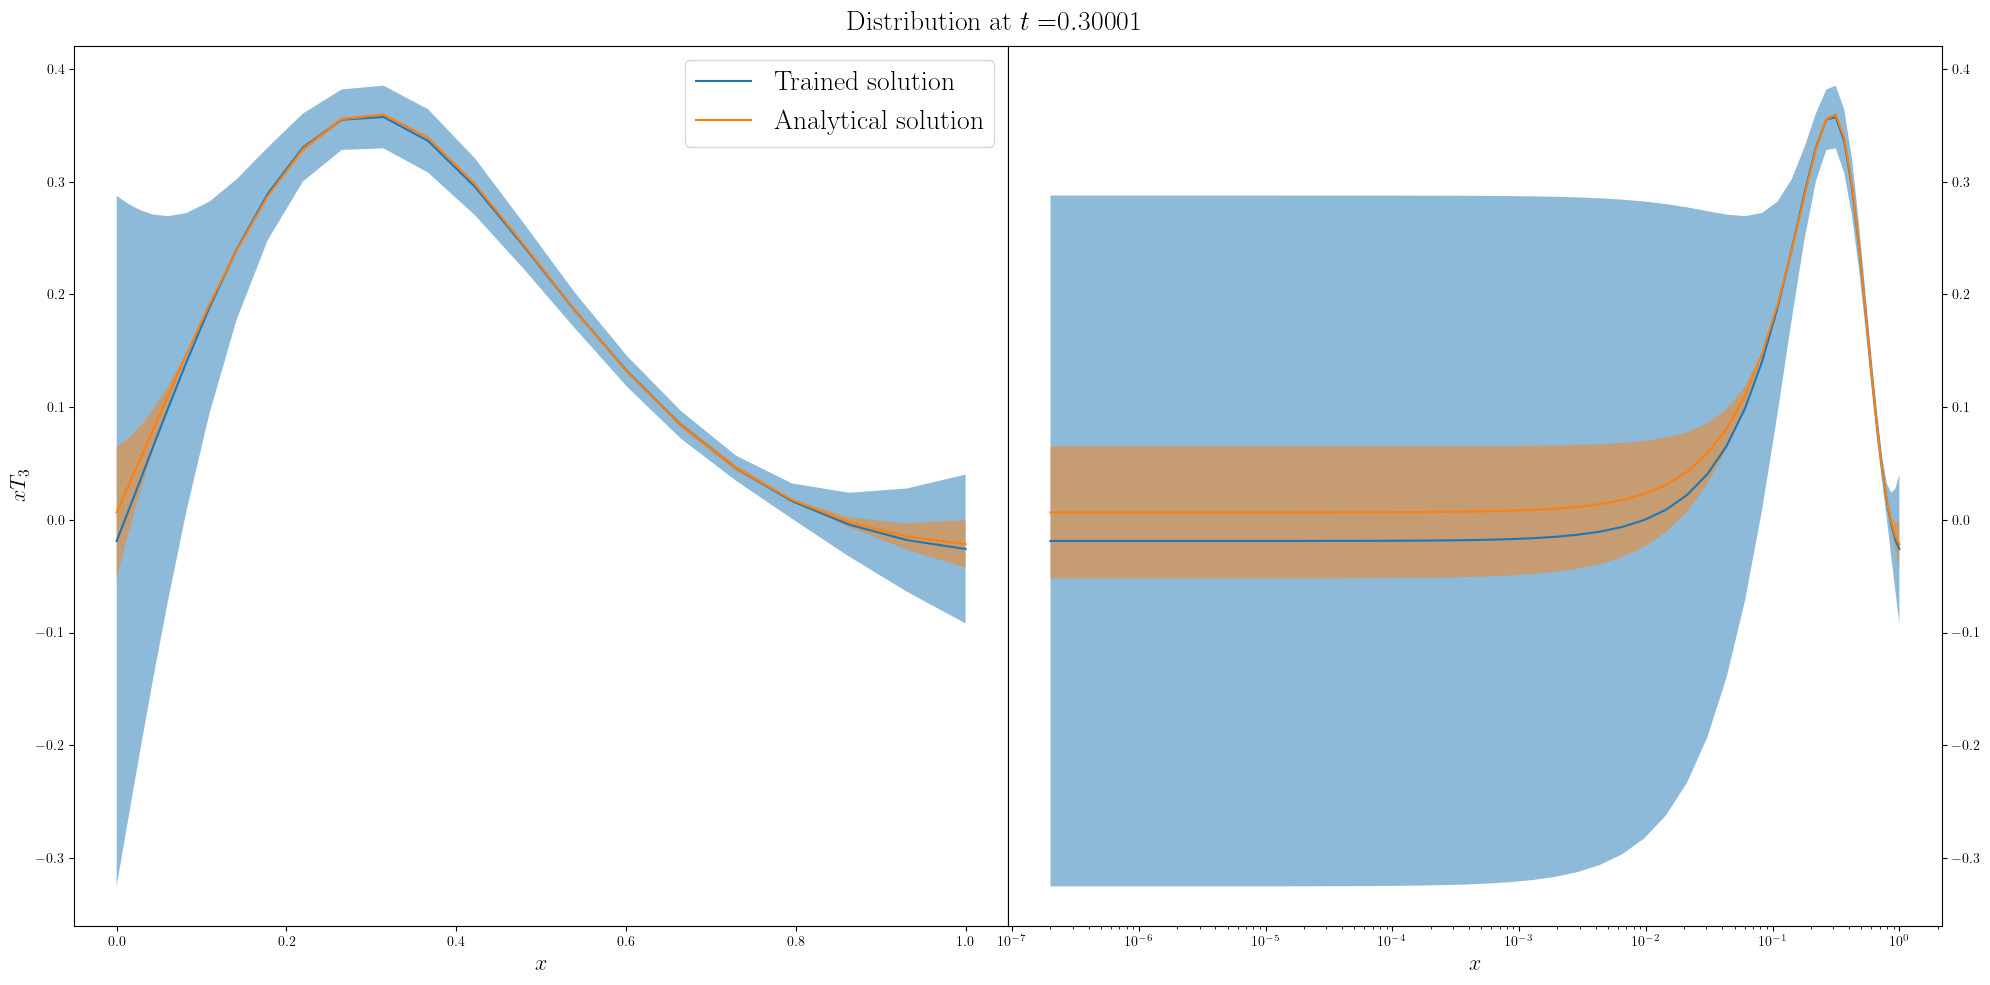

In [25]:
xT3_t = compute_evolution_t(t, xT3_ref, ref_epoch, fluctuate_data=False, fluctuate_ntk=False)

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})

# xf linaer
axs[0].plot(fk_grid, xT3_ref.get_mean(), label=r'$\textrm{Trained solution}$')
axs[0].fill_between(fk_grid, xT3_ref.get_mean() - xT3_ref.get_std(), xT3_ref.get_mean() + xT3_ref.get_std(), alpha=0.5)
axs[0].plot(fk_grid, xT3_t.get_mean(), label=r'$\textrm{Analytical solution}$')
axs[0].fill_between(fk_grid, xT3_t.get_mean() - xT3_t.get_std(), xT3_t.get_mean() + xT3_t.get_std(), alpha=0.5)

# xf log
axs[1].plot(fk_grid, xT3_ref.get_mean())
axs[1].fill_between(fk_grid, xT3_ref.get_mean() - xT3_ref.get_std(), xT3_ref.get_mean() + xT3_ref.get_std(), alpha=0.5)
axs[1].plot(fk_grid, xT3_t.get_mean())
axs[1].fill_between(fk_grid, xT3_t.get_mean() - xT3_t.get_std(), xT3_t.get_mean() + xT3_t.get_std(), alpha=0.5)
axs[1].set_xscale('log')
axs[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)


axs[0].set_ylabel(r'$xT_3$', fontsize=16)
axs[0].set_xlabel(r'$x$', fontsize=16)
axs[1].set_xlabel(r'$x$', fontsize=16)

axs[0].legend(fontsize=20)

fig.suptitle(r'$\textrm{Distribution at } t =$' + rf'${t}$', fontsize=20)
fig.tight_layout()
if SAVE_PLOT:
  fig.savefig(PLOT_FOLDER / 'xT3_3.png', dpi=300)

# 4) As 2) fluctuating initialization and data

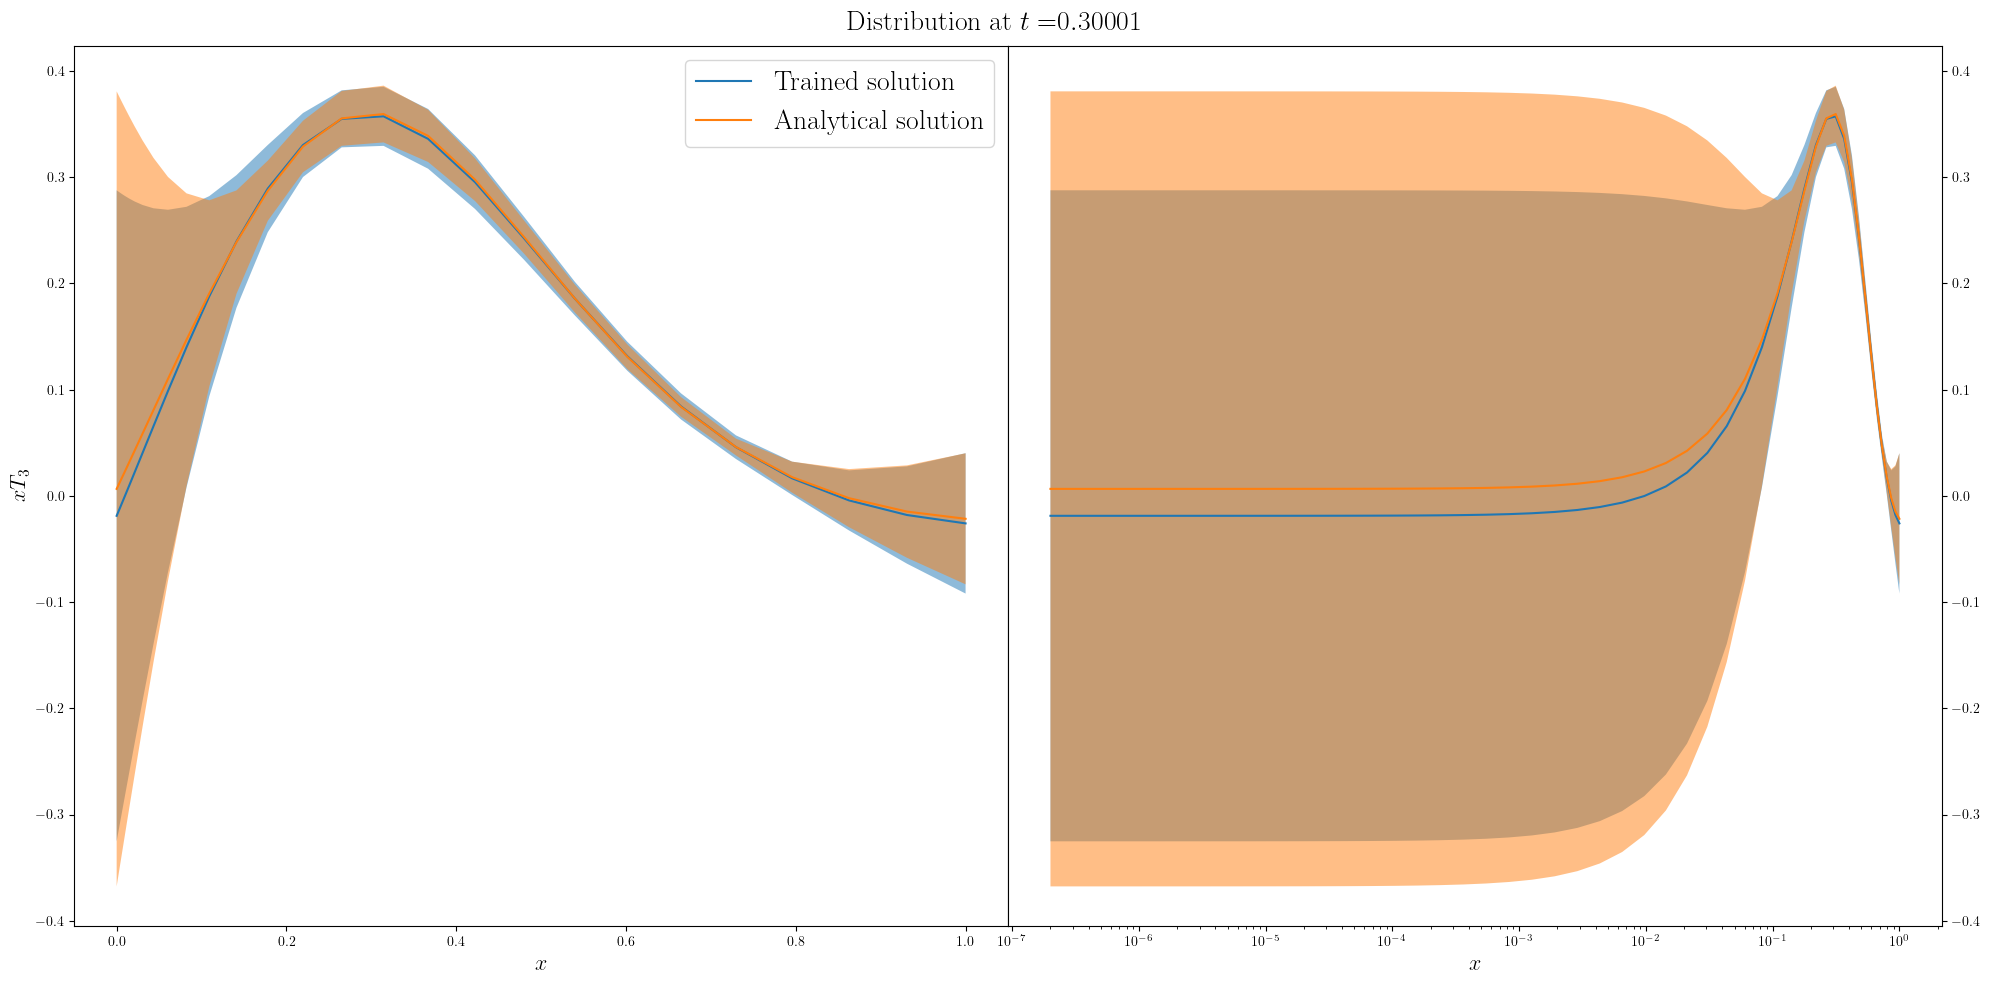

In [26]:
xT3_t = compute_evolution_t(t, xT3_ref, ref_epoch, fluctuate_data=True, fluctuate_ntk=False)

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})

# xf linaer
axs[0].plot(fk_grid, xT3_ref.get_mean(), label=r'$\textrm{Trained solution}$')
axs[0].fill_between(fk_grid, xT3_ref.get_mean() - xT3_ref.get_std(), xT3_ref.get_mean() + xT3_ref.get_std(), alpha=0.5)
axs[0].plot(fk_grid, xT3_t.get_mean(), label=r'$\textrm{Analytical solution}$')
axs[0].fill_between(fk_grid, xT3_t.get_mean() - xT3_t.get_std(), xT3_t.get_mean() + xT3_t.get_std(), alpha=0.5)

# xf log
axs[1].plot(fk_grid, xT3_ref.get_mean())
axs[1].fill_between(fk_grid, xT3_ref.get_mean() - xT3_ref.get_std(), xT3_ref.get_mean() + xT3_ref.get_std(), alpha=0.5)
axs[1].plot(fk_grid, xT3_t.get_mean())
axs[1].fill_between(fk_grid, xT3_t.get_mean() - xT3_t.get_std(), xT3_t.get_mean() + xT3_t.get_std(), alpha=0.5)
axs[1].set_xscale('log')
axs[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)


axs[0].set_ylabel(r'$xT_3$', fontsize=16)
axs[0].set_xlabel(r'$x$', fontsize=16)
axs[1].set_xlabel(r'$x$', fontsize=16)

axs[0].legend(fontsize=20)

fig.suptitle(r'$\textrm{Distribution at } t =$' + rf'${t}$', fontsize=20)
fig.tight_layout()
if SAVE_PLOT:
  fig.savefig(PLOT_FOLDER / 'xT3_4.png', dpi=300)

# 5) As 2) fluctuating initialization, data, and ntk

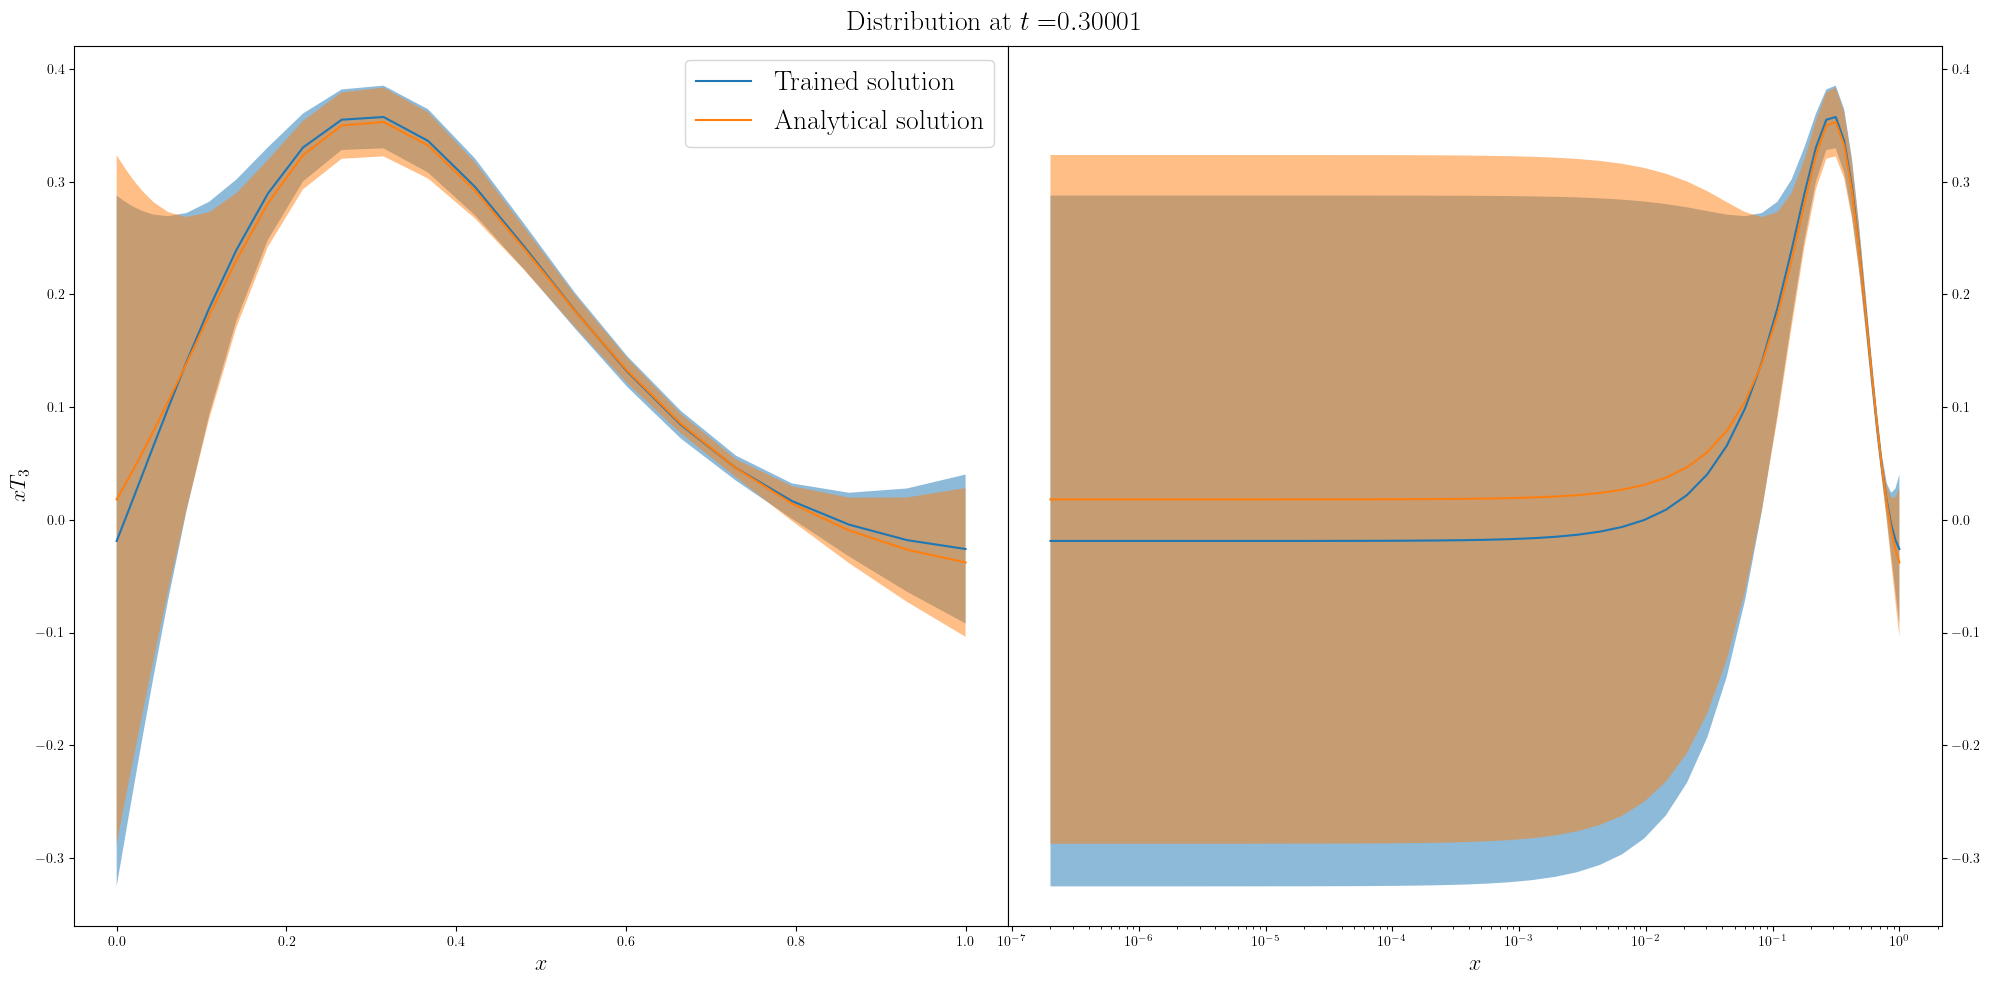

In [27]:
xT3_t = compute_evolution_t(t, xT3_ref, ref_epoch, fluctuate_data=True, fluctuate_ntk=True)

fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=False, gridspec_kw={'hspace': 0., 'wspace': 0.})

# xf linaer
axs[0].plot(fk_grid, xT3_ref.get_mean(), label=r'$\textrm{Trained solution}$')
axs[0].fill_between(fk_grid, xT3_ref.get_mean() - xT3_ref.get_std(), xT3_ref.get_mean() + xT3_ref.get_std(), alpha=0.5)
axs[0].plot(fk_grid, xT3_t.get_mean(), label=r'$\textrm{Analytical solution}$')
axs[0].fill_between(fk_grid, xT3_t.get_mean() - xT3_t.get_std(), xT3_t.get_mean() + xT3_t.get_std(), alpha=0.5)

# xf log
axs[1].plot(fk_grid, xT3_ref.get_mean())
axs[1].fill_between(fk_grid, xT3_ref.get_mean() - xT3_ref.get_std(), xT3_ref.get_mean() + xT3_ref.get_std(), alpha=0.5)
axs[1].plot(fk_grid, xT3_t.get_mean())
axs[1].fill_between(fk_grid, xT3_t.get_mean() - xT3_t.get_std(), xT3_t.get_mean() + xT3_t.get_std(), alpha=0.5)
axs[1].set_xscale('log')
axs[1].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)


axs[0].set_ylabel(r'$xT_3$', fontsize=16)
axs[0].set_xlabel(r'$x$', fontsize=16)
axs[1].set_xlabel(r'$x$', fontsize=16)

axs[0].legend(fontsize=20)

fig.suptitle(r'$\textrm{Distribution at } t =$' + rf'${t}$', fontsize=20)
fig.tight_layout()
if SAVE_PLOT:
  fig.savefig(PLOT_FOLDER / 'xT3_5.png', dpi=300)

# Plot of the eigenvectors

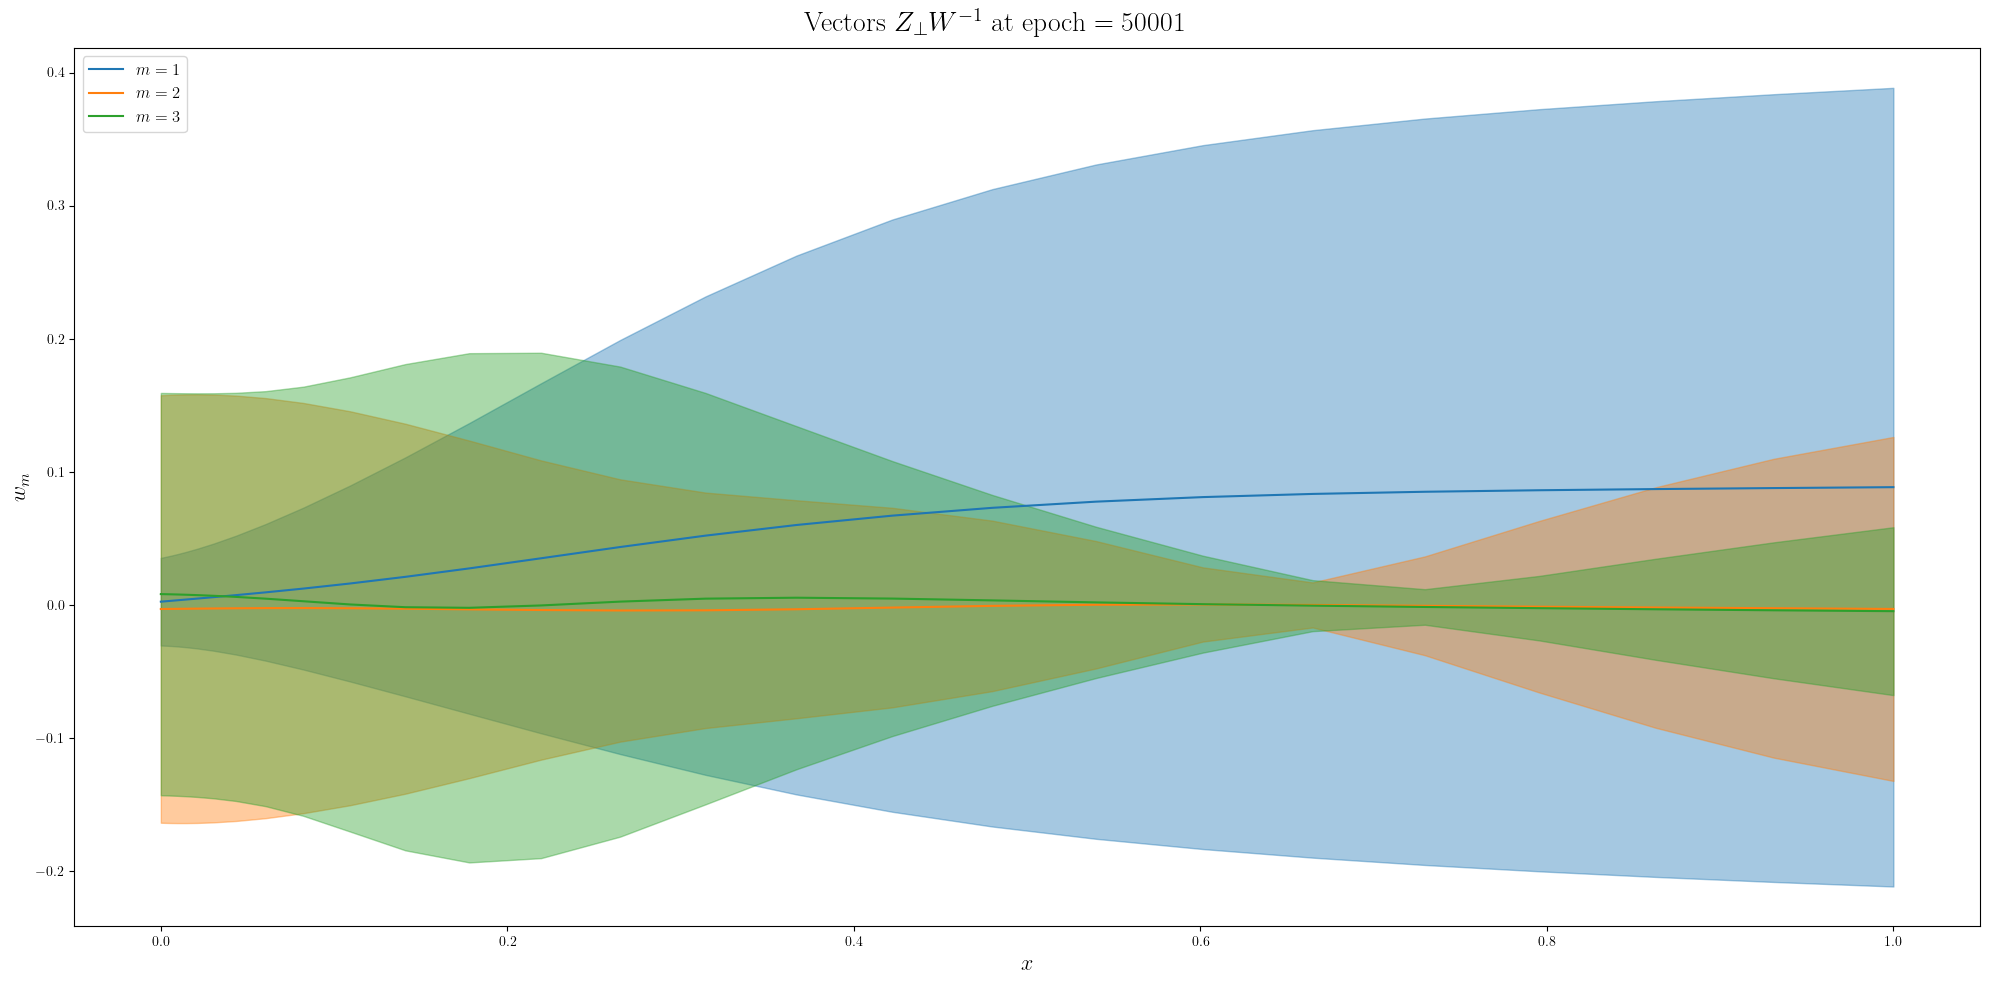

In [28]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))

components = 3
vectors_distribution = []

epoch = 50001
results_by_replica = collect_by_replica(epoch, xT3_0, fluctuate_ntk=True, fluctuate_data=True)

for rep in range(replicas):
  W = results_by_replica.W[rep]
  Z_perp = results_by_replica.Z_perp[rep]
  vectors_distribution.append(Z_perp @ np.linalg.inv(W))

vec0 = [vec[:,0] for vec in vectors_distribution]
mean0 = np.mean(vec0, axis=0)
std0 = np.std(vec0, axis=0)
axs.plot(fk_grid, mean0, label=r'$m=1$', color='C0')
axs.fill_between(fk_grid, mean0 - std0, mean0 + std0, color='C0', alpha=0.4)

vec1 = [vec[:,1] for vec in vectors_distribution]
mean1 = np.mean(vec1, axis=0)
std1 = np.std(vec1, axis=0)
axs.plot(fk_grid, mean1, label=r'$m=2$', color='C1')
axs.fill_between(fk_grid, mean1 - std1, mean1 + std1, color='C1', alpha=0.4)

vec2 = [vec[:,2] for vec in vectors_distribution]
mean2 = np.mean(vec2, axis=0)
std2 = np.std(vec2, axis=0)
axs.plot(fk_grid, mean2, label=r'$m=3$', color='C2')
axs.fill_between(fk_grid, mean2 - std2, mean2 + std2, color='C2', alpha=0.4)

axs.legend(fontsize=12)
axs.set_xlabel(r'$x$', fontsize=16)
axs.set_ylabel(r'$w_m$', fontsize=16)

fig.suptitle(r'$\textrm{Vectors } Z_{\perp} W^{-1} \textrm{ at epoch} = $' + fr'$\;{epoch}$', fontsize=20)

fig.tight_layout()
if SAVE_PLOT:
  fig.savefig(PLOT_FOLDER / 'eigenvectors.png', dpi=300)

In [29]:
# Save and convert the notebook to HTML
import os

# Convert the notebook to HTML
def convert_to_html(notebook_filename):
    os.system(f"jupyter nbconvert --to html {notebook_filename} --output-dir {FIT_FOLDER} --output analysis")
    print(f"Notebook converted to HTML: {notebook_filename.replace('.ipynb', '.html')}")

In [30]:
if SAVE_NB:
  convert_to_html('full_evolution.ipynb')
  print("Notebook saved and converted to HTML.")